In [ ]:
!pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 98.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uni

**Prepared Dataset and The Other Stuffs**
---
Menyiapkan dataset dan semua library yang dibutuhkan

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import itertools
from google.colab import drive

%matplotlib inline

In [ ]:
print(tf.__version__)

2.9.1


In [ ]:
drive.mount('/content/drive')
DATASET_DIR = '/content/drive/MyDrive/DATASETS'
BATCH_SIZE = 32
IMG_HEIGHT = 300
IMG_WIDTH = 300
SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

Mounted at /content/drive


***Split to Train, Test, Val and Preprocessed Dataset***
---
Dataset di split ke dalam train test dan val, dengan rasio 0.8, 0.1, 0.1 .
Juga dilakukan shuffle, augmentasi, dan lain lain.

In [ ]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=345,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

# Make Val Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=345,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(dataset=val_ds)
test_ds = val_ds.take((1 * val_batches) // 2)
val_ds = val_ds.skip((1 * val_batches) // 2)

print('\nSPLITTING VALIDATION FOR TESTING:')
print(f'Using {tf.data.experimental.cardinality(dataset=val_ds) * BATCH_SIZE} files for validation')
print(f'Using {tf.data.experimental.cardinality(dataset=test_ds) * BATCH_SIZE} files for testing')


Found 9357 files belonging to 13 classes.
Using 7486 files for training.
Found 9357 files belonging to 13 classes.
Using 1871 files for validation.

SPLITTING VALIDATION FOR TESTING:
Using 960 files for validation
Using 928 files for testing


['Jagung_Bercak_Daun', 'Jagung_Hawar_Daun', 'Jagung_Karat_Daun', 'Jagung_Sehat', 'Kentang_Bercak_Kering', 'Kentang_Busuk_Daun', 'Kentang_Sehat', 'Kentang_Virus', 'Padi_Bercak_Cokelat', 'Padi_Blast', 'Padi_Hawar_Daun', 'Padi_Hispa', 'Padi_Sehat']


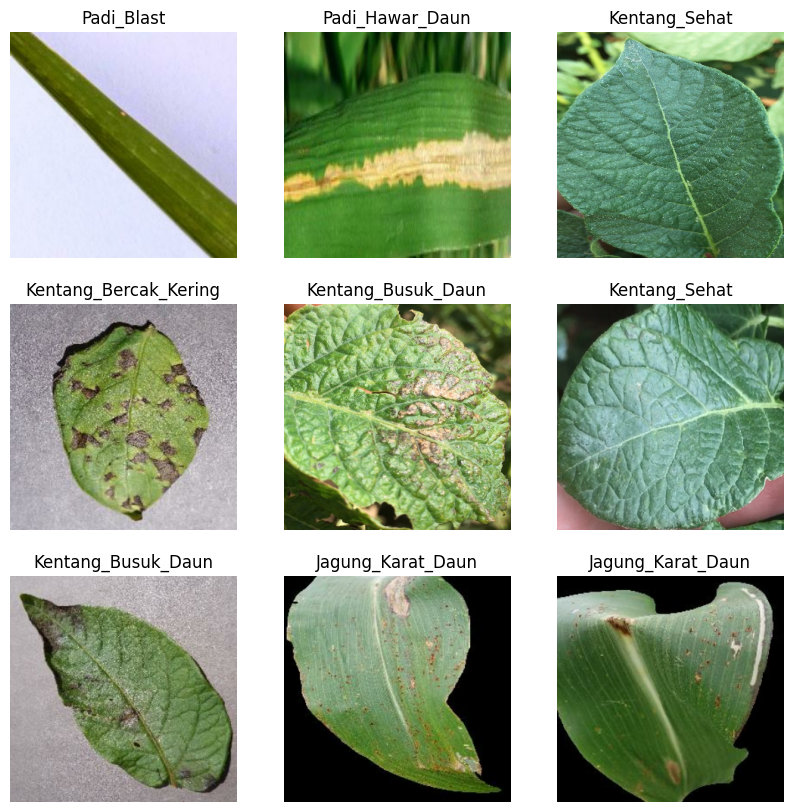

In [ ]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(factor=0.2),
  tf.keras.layers.RandomBrightness(factor=[-0.3,0.3]),
  tf.keras.layers.RandomContrast(factor=0.2)
])

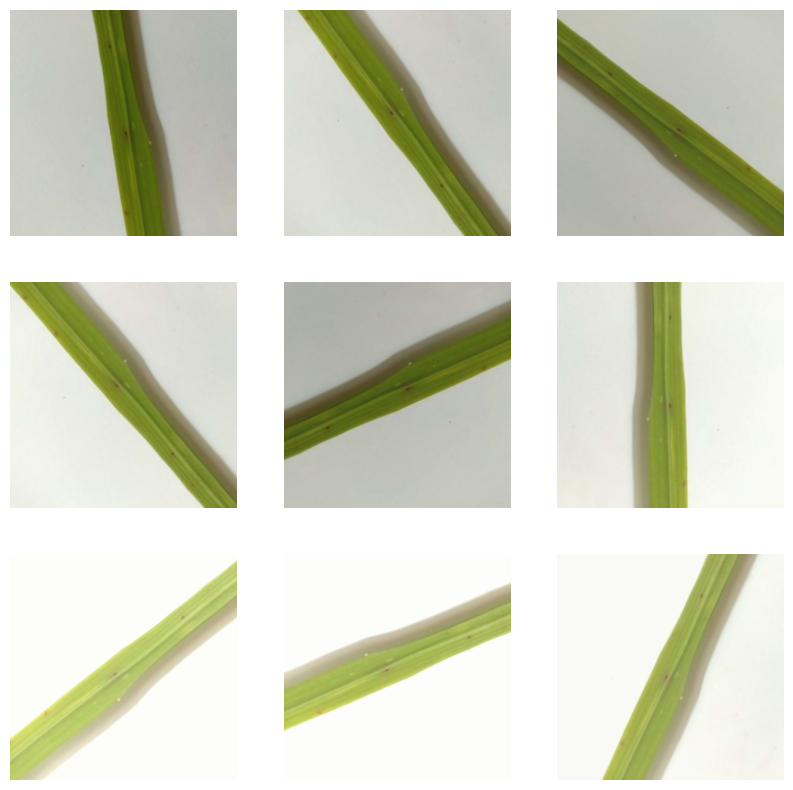

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
train_ds = train_ds.cache().shuffle(buffer_size=BATCH_SIZE*100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

***Create a Callback Function***
---
Membuat fungsi callback yang diperlukan

In [ ]:
class myCallback(keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.97:
                print("\nReached 98% accuracy so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

stop_callback = myCallback()

***Model Architecture***
---
Membuat model dengan transfer learning dan layers tambahan

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(input_shape=(300,300,3), include_top=False, weights='imagenet')
base_model.trainable = True

43941136/43941136 [==============================] - 2s 0us/step


In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  385


In [ ]:
# Fine-tune from this layer onwards
layer_tune = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:layer_tune]:
  layer.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(300,300,3)),
    data_augmentation,
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(13, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          442400    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 64)         0         
 2D)                                                  

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
history_ft = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks=[stop_callback])

Epoch 1/50


234/234 [==============================] - 1554s 2s/step - loss: 1.3311 - accuracy: 0.5390 - val_loss: 0.5207 - val_accuracy: 0.7953
Epoch 2/50
234/234 [==============================] - 137s 585ms/step - loss: 0.5858 - accuracy: 0.7927 - val_loss: 0.4005 - val_accuracy: 0.8600
Epoch 3/50
234/234 [==============================] - 138s 592ms/step - loss: 0.4372 - accuracy: 0.8464 - val_loss: 0.3138 - val_accuracy: 0.8865
Epoch 4/50
234/234 [==============================] - 138s 590ms/step - loss: 0.3756 - accuracy: 0.8700 - val_loss: 0.2927 - val_accuracy: 0.8929
Epoch 5/50
234/234 [==============================] - 138s 589ms/step - loss: 0.3281 - accuracy: 0.8831 - val_loss: 0.2924 - val_accuracy: 0.8993
Epoch 6/50
234/234 [==============================] - 138s 589ms/step - loss: 0.2878 - accuracy: 0.8999 - val_loss: 0.2555 - val_accuracy: 0.9056
Epoch 7/50
234/234 [==============================] - 138s 590ms/step - loss: 0.2582 - accuracy: 0.9126 - val_loss: 0.3075 - val_accuracy

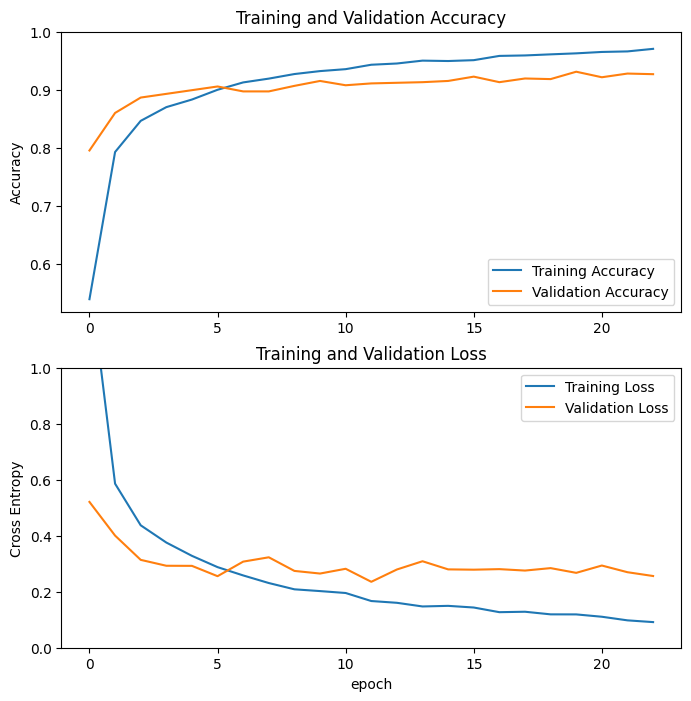

In [ ]:
acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

***Testing Model***
---
Cek akurasi model dengan data test yang sudah dibuat

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

29/29 [==============================] - 7s 201ms/step - loss: 0.3150 - accuracy: 0.9203
Test accuracy : 0.920258641242981


In [ ]:
test_data = list(test_ds)
features = np.concatenate([test_data[n][0] for n in range(0, len(test_data))])
targets = np.concatenate([test_data[n][1] for n in range(0, len(test_data))])

In [ ]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(features)

29/29 [==============================] - 8s 184ms/step


Predictions:
 [[0.06794272 0.18468742 0.06794272 ... 0.06794272 0.06794272 0.06794272]
 [0.06810421 0.06810423 0.06810421 ... 0.06810679 0.06812473 0.06810569]
 [0.06794275 0.06794275 0.06794275 ... 0.06794275 0.06794275 0.06794281]
 ...
 [0.069668   0.06966799 0.06966795 ... 0.06967542 0.06967482 0.06967977]
 [0.06965499 0.06893189 0.06858704 ... 0.06859118 0.06911638 0.06878502]
 [0.06799141 0.06799141 0.06799141 ... 0.06799141 0.06841144 0.18368182]]
Labels:
 [ 1  9  8 12  5  7  4 11  7  0  0  1 12 12  3 11 12  1  4  8  4  0  8  3
  4  3  4  9 12  1 10  9  5  0  0  0  7 12  4  1  0  4 12 10  5  0  4  0
  2  9  6 10 12 12  0  4  9 10  4 12  0  9  4  5  2 12 10 10  0  1 10  9
  0 11 10  7  1 11 12  9  7  6  9  7  1  5  4  6 12  6  0  6  5  5  0  2
  8  7  2 11  6  7  5  7  8  6 12  6  9 10  4  8  6  9  2 10  7  0  5  6
  1  2  1  4 10  8  5  1  6  2 10  0  5  2  6  6  0  2  4 12  8  7  6  3
  7 12  2  8  7  4 12  3  2  0 11 10  8  5  2  4  8  5  4  1  5 12  3 12
  2 11  9  2  6  9  1 

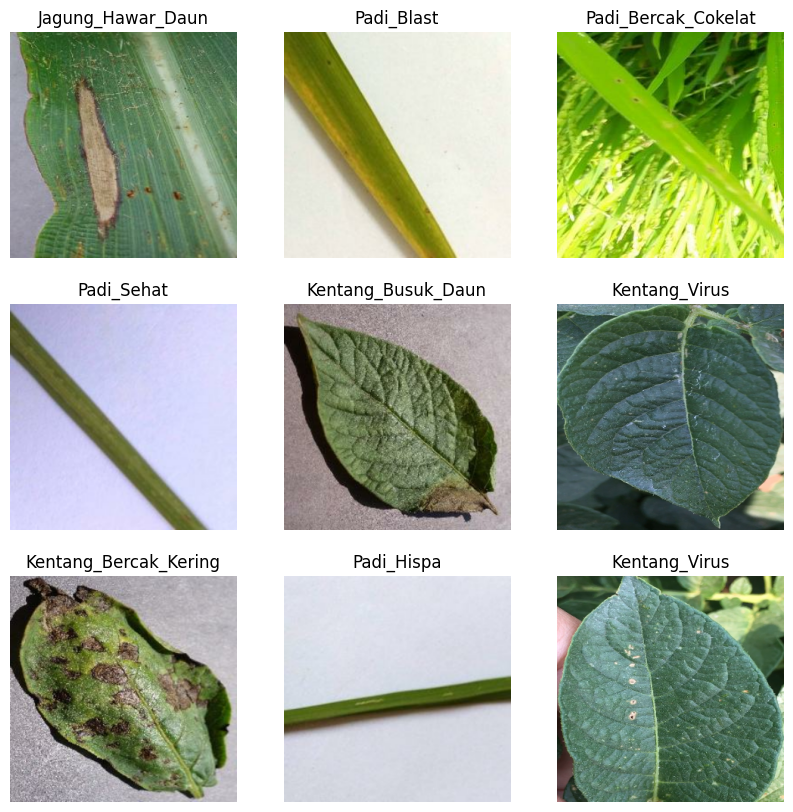

In [ ]:
print('Predictions:\n', predictions)
print('Labels:\n', targets)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(features[i].astype("uint8"))

  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

***Monitoring Akurasi***
---
Membuat Confusion Materix dan Classification Report

###Confusion Matrix

In [ ]:
y_true = targets
y_pred = np.argmax(predictions, axis=-1)

In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)

In [ ]:
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize = (12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30)
    plt.yticks(tick_marks, classes)

    print(cm)
    print()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
conf_mat_labels = class_names

[[70  6  0  0  0  0  0  0  0  0  0  0  0]
 [10 61  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 69  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0 69  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 71  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 61  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 55  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  1 67  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 64  8  0  0  2]
 [ 0  0  0  0  0  0  0  0  1 53  0 13  5]
 [ 0  0  0  0  0  0  0  0  0  0 75  0  0]
 [ 0  0  0  0  0  0  0  0  1  2  0 72  4]
 [ 0  0  0  0  0  0  0  0  1  1  0  5 67]]



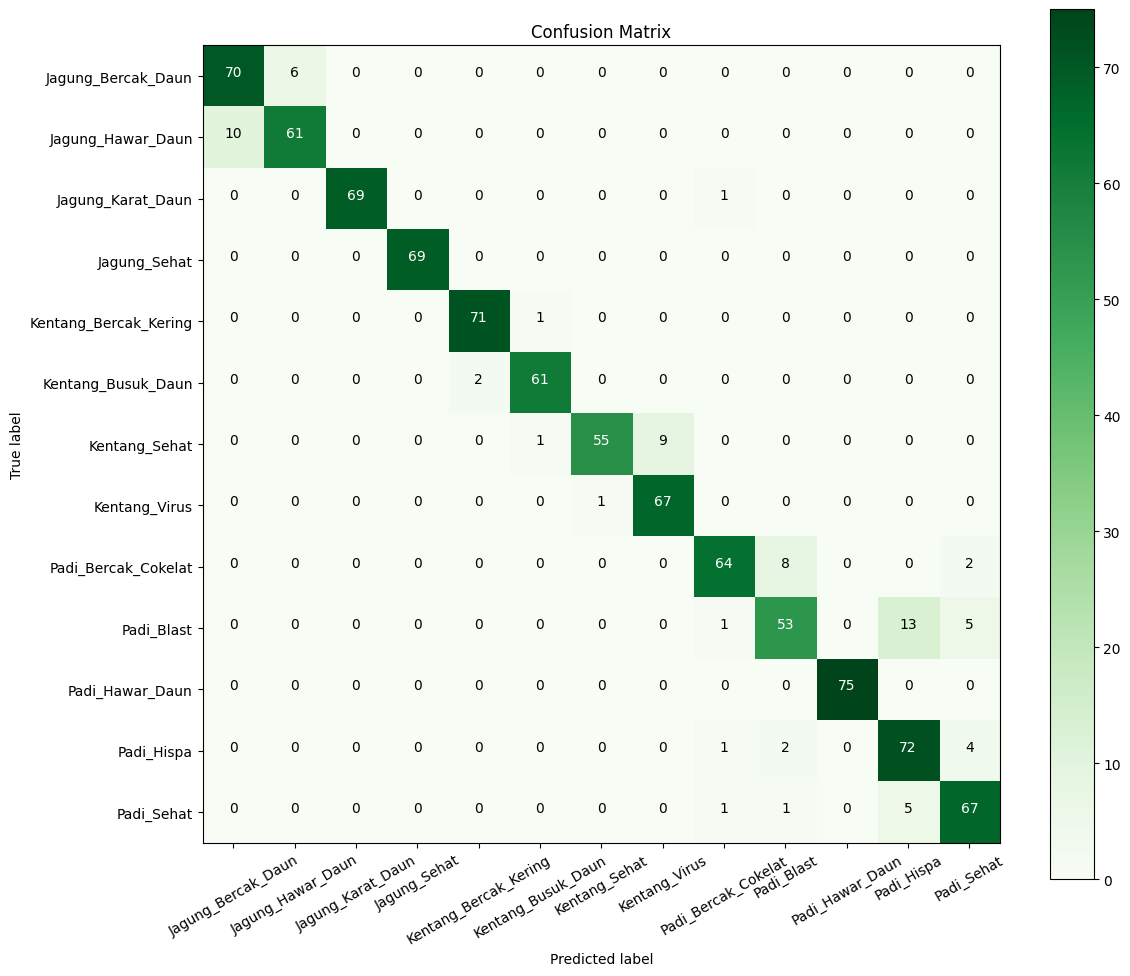

In [ ]:
show_confusion_matrix(cm=conf_mat, classes=conf_mat_labels, title='Confusion Matrix')

###Classification Report

---

Akurasi, presisi, recall, f-1 score

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

   Jagung_Bercak_Daun       0.88      0.92      0.90        76
    Jagung_Hawar_Daun       0.91      0.86      0.88        71
    Jagung_Karat_Daun       1.00      0.99      0.99        70
         Jagung_Sehat       1.00      1.00      1.00        69
Kentang_Bercak_Kering       0.97      0.99      0.98        72
   Kentang_Busuk_Daun       0.97      0.97      0.97        63
        Kentang_Sehat       0.98      0.85      0.91        65
        Kentang_Virus       0.88      0.99      0.93        68
  Padi_Bercak_Cokelat       0.94      0.86      0.90        74
           Padi_Blast       0.83      0.74      0.78        72
      Padi_Hawar_Daun       1.00      1.00      1.00        75
           Padi_Hispa       0.80      0.91      0.85        79
           Padi_Sehat       0.86      0.91      0.88        74

             accuracy                           0.92       928
            macro avg       0.92      0.92      0.92 

**Save Model (.h5) and Convert to TFJS **

In [ ]:
saved_model_path = '/content/drive/MyDrive/Model_GrowPlants/model.h5'
model.save(saved_model_path)

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 109.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninsta

In [ ]:
!tensorflowjs_converter --input_format keras /content/drive/MyDrive/Model_GrowPlants/model.h5 /content/drive/MyDrive/Model_GrowPlants/Model

2023-06-12 19:20:22.990944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
weight normalization/count with shape () and dtype int64 was auto converted to the type int32
